<a href="https://colab.research.google.com/github/YuruHuang/COVID-ZIP/blob/master/MenuHealthiness_ML_DL_Models_resampled.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, I will run various machine learning experiments where I will use `rest_name` to predict expert `menu healthiness scores`. The best performing model will be saved for each experiment. 

Below is a summary of what I am going to do in this notebook: 

**Data Cleaning**
- remove special characters, puncutuations 
- remove chain locations 
- split train test sets 
- get the average score for chains with the same name in the training set (McDonald's will have the same score)

**ML/DL experiments**
- **Model 0 (ML)**: Baseline model with only rest_name (Support Vector Regression, tf-idf)
- **Model 1 (DL)**: LSTM model with word level tokenization
- **Model 2 (DL)**: LSTM model with character level tokenization
- **Model 3 (DL)**: GRU model with word level tokenization
- **Model 4 (DL)**: GRU model with character level tokenization
- **Model 5 (DL)**: CNN model with word level tokenization
- **Model 6 (transfer learning)**: pre-trained embedding layer (ULM) 
- **Model 7 (transfer learning)**: pre-trained embedding layer and fine tuning. 
- **Model 8 (DL)**: GRU model with word level tokenization, added food hygiene rating
- **Model 9 (DL)**: GRU model with character level tokenization, added food hygiene rating
- **Model 10 (DL)**: GRU model with character level tokenization, added food hygiene rating, and changed the activation


## Data preprocessing 

In [ ]:
## Import all the libraries 
!pip install unidecode
from unidecode import unidecode
import string
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, f1_score, accuracy_score,classification_report,explained_variance_score, r2_score, mean_absolute_percentage_error
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import layers
from sklearn.model_selection import GridSearchCV
import seaborn as sns
#!pip install smogn
from collections import Counter
from joblib import dump, load

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Examine the data 

In [ ]:
train_ds = pd.read_csv('train_smogn.csv')
test_ds = pd.read_csv('test_smogn.csv')

In [ ]:
train_ds.shape, test_ds.shape

((56902, 25), (5458, 26))

In [ ]:
# 0-12 if over 12 then 12
def clean_data(data):
  data.loc[data['predict']>12, 'predict'] = 12
  data.loc[data['predict']<0, 'predict'] = 0
  return data

In [ ]:
train_ds = clean_data(train_ds)
test_ds = clean_data(test_ds)

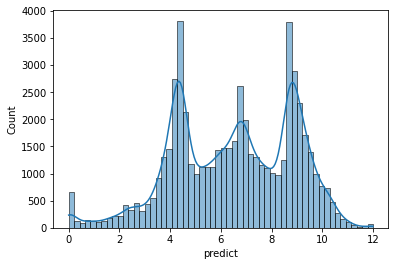

In [ ]:
sns.histplot(train_ds.predict,kde=True)

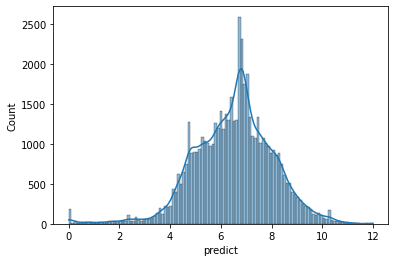

In [ ]:
sns.histplot(justeat_menu.predict,kde=True)

## Clean the data 

### remove/replace punctuations 


In [ ]:
def rest_name_cleaning(rest_name):
  '''
  This function cleans the restaurant name string 
  '''
  rest_name_clean = rest_name.lower()
  rest_name_clean = rest_name_clean.strip()
  ascii_name = unidecode(rest_name_clean)
  ascii_name_fix = ascii_name.replace('`',"'")
  ascii_name_fix = ascii_name_fix.replace('~'," ")
  ascii_name_fix = ascii_name_fix.replace(']'," ")
  ascii_name_fix = ascii_name_fix.replace('['," ")
  ascii_name_fix = ascii_name_fix.replace('\\'," ")
  ascii_name_fix = ascii_name_fix.replace('%'," ")
  ascii_name_fix = ascii_name_fix.replace('*'," ")
  ascii_name_fix = ascii_name_fix.replace('+'," and ")
  ascii_name_fix = ascii_name_fix.replace('&'," and ")
  ascii_name_fix = ascii_name_fix.replace('/'," ") 
  
  return ascii_name_fix

In [ ]:
train_ds['ascii_name_fix'] = train_ds.rest_name.apply(lambda x: rest_name_cleaning(x))
test_ds['ascii_name_fix'] = test_ds.rest_name.apply(lambda x: rest_name_cleaning(x))

In [ ]:
train_ds

,Unnamed: 0,index,Restaurant ID,Desserts,Vegetables,Salads,Chips,Water,Milk,Special Offers,...,price_min,price_max,postcode,postcode_district,specialOffers,chips,salads,predict,rating2,ascii_name_fix
0,0,21615,37196,1,18,4,1,0,0,3,...,0.317419,44.105129,G12 8TN,G12,3,1,4,8.568073,3,la vita spuntini
1,1,21158,38498,1,18,4,2,0,0,3,...,0.330876,44.440739,G12 8TN,G12,3,1,4,8.556266,2,la vita spuntini
2,2,20740,35972,2,17,5,2,0,0,3,...,0.300338,44.254935,G12 8TN,G12,2,2,5,8.546312,3,la vita spuntini
3,3,25787,95230,0,17,2,0,0,0,4,...,2.949059,120.214755,G12 8TN,G12,4,0,2,8.555663,3,la vita spuntini
4,4,26378,94912,0,16,3,0,0,0,4,...,2.933776,119.953226,G12 8TN,G12,4,0,2,8.538543,3,la vita spuntini
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56897,11805,35652,136390,0,6,0,28,0,0,20,...,0.513422,24.900960,NE5 5BS,NE5,9,14,0,4.446339,0,sugar shack
56898,11806,15334,93479,2,7,1,13,0,0,12,...,0.393716,36.147208,NE5 5BS,NE5,9,12,1,4.515520,0,sugar shack
56899,11807,34316,105749,62,5,1,5,0,0,1,...,0.320822,13.762017,NE5 5BS,NE5,0,4,1,3.321277,0,sugar shack
56900,11808,44254,104782,3,8,2,13,0,0,11,...,0.476740,20.117191,NE5 5BS,NE5,9,12,2,4.576050,0,sugar shack


In [ ]:
X_train = train_ds.ascii_name_fix
y_train = train_ds.predict
X_test_ = test_ds.ascii_name_fix
y_test_ = test_ds.predict

In [ ]:
from sklearn.model_selection import train_test_split
# now split the test and validation set (5% each, and 90% for training)
X_test, X_val, y_test, y_val = train_test_split(X_test_, y_test_, random_state = 42, test_size = 0.5) 

In [ ]:
X_train.shape, X_test.shape, X_val.shape

((56902,), (2729,), (2729,))

# READY FOR MODEL TRAINING!!

## Model 0 (ML): Baseline model 

Using support vector regression (benchmark) only 

In [ ]:
# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("svr", SVR()) # model the scores
])

# Fit the pipeline to the training data
model_0.fit(X_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('svr', SVR())])

In [ ]:
from joblib import dump
dump(model_0, 'model_0_190722_resampled.joblib')

['model_0_190722_resampled.joblib']

In [ ]:
#from joblib import load
#model_0 = load('model_0_270422.joblib') 
#-> model with average values from food outlets with the same name (should we?)

I have done hyperparameter tuning and the best performing model has the default parameters (In notebook `06_Applying_the_Model.ipynb`). 

> `Best parameter (CV score=0.409):
{'svr__C': 1, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}`



In [ ]:
# Evaluate the model performance on test set 

# set up model prediction and metrics 
def evaluate_preds(model_name, y_true, X_test):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = model_name.predict(X_test)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy()}


In [ ]:
evaluate_preds(model_0, y_train, X_train)

{'mae': 0.5939533, 'mape': 39683576.0, 'mse': 0.9335126, 'rmse': 0.96618456}

In [ ]:
evaluate_preds(model_0, y_test_, X_test_)

{'mae': 0.86834913, 'mape': 12515712.0, 'mse': 1.430205, 'rmse': 1.1959118}

In [ ]:
# If we assume mean values for prediction, what would the outcome be?
mean_absolute_error(y_test,[np.mean(y_train.to_list())]*len(y_test)) #if we assume mean values

1.1863973972209403

### some prediction examples 

In [ ]:
# prediction examples
names_to_predict = ['X\'s fish & chip shop', 'Yuru\'s Pizza & Kebab', 'Yuru\'s Chinese Takeaways','Yuru\'s Sushi Takeaways','Yuru\'s Sushi Restaurant','Yuru\'s Cocktail Bar',
                    'Cambridge Oven','Yo!Sushi','Starbucks','Vanderlyle']
names_to_predict2 = [rest_name_cleaning(name) for name in names_to_predict]
pd.DataFrame(zip(names_to_predict,model_0.predict(names_to_predict2)),columns=['rest_name','predicted_score'])

,rest_name,predicted_score
0,X's fish & chip shop,5.121290
1,Yuru's Pizza & Kebab,4.941605
2,Yuru's Chinese Takeaways,6.452868
3,Yuru's Sushi Takeaways,10.234860
4,Yuru's Sushi Restaurant,11.225519
5,Yuru's Cocktail Bar,6.586805
6,Cambridge Oven,7.005949
7,Yo!Sushi,9.475604
8,Starbucks,7.416714
9,Vanderlyle,5.922581


In [ ]:
# Apply this model to POI 
poi = read_csv('poi-extract-2021_03.csv')

In [ ]:
# clean the restaurant names 


### Set up model callbacks 

Create a small function to create a ModelCheckpoint callback which saves a model to specified filename. Because we are going to run multiple experiments, we will keep track of them (save the best model) 

In [ ]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            save_best_only=True, verbose=0) # save only the best model to file

# create a function for early stopping 
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

##Model 1 (DL): LSTM model, word level tokenization


In [ ]:
# create tensorflow datasets for training
X_train = tf.data.Dataset.from_tensor_slices(X_train)
X_test = tf.data.Dataset.from_tensor_slices(X_test)
X_val = tf.data.Dataset.from_tensor_slices(X_val)

In [ ]:
y_train =tf.data.Dataset.from_tensor_slices(y_train)
y_test =tf.data.Dataset.from_tensor_slices(y_test)
y_val = tf.data.Dataset.from_tensor_slices(y_val)

In [ ]:
train_ds_word =  tf.data.Dataset.zip((X_train,y_train))
test_ds_word =  tf.data.Dataset.zip((X_test,y_test))
val_ds_word =  tf.data.Dataset.zip((X_val,y_val))

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
train_ds_word = train_ds_word.shuffle(buffer_size=512).batch(batch_size, drop_remainder=True).cache().prefetch(buffer_size=AUTOTUNE)
test_ds_word = test_ds_word.shuffle(buffer_size=512).batch(batch_size, drop_remainder=True).cache().prefetch(buffer_size=AUTOTUNE)
val_ds_word =val_ds_word.shuffle(buffer_size=512).batch(batch_size, drop_remainder=True).cache().prefetch(buffer_size=AUTOTUNE)

###Word level tokenization 

In [ ]:
max_vocab_length=20000
max_length = 10 # max length our sequences will be (e.g. how many words from the restaurant name does our model see?)

word_vectorizer = TextVectorization(output_mode="int",
                                    max_tokens = max_vocab_length,
                                    split = "whitespace",
                                    standardize ="lower_and_strip_punctuation",
                                    output_sequence_length=max_length)

In [ ]:
# Find average number of tokens (words) in training restaurant names
round(sum([len(i.split()) for i in X_train])/len(X_train)), max([len(i.split()) for i in X_train])

(3, 10)

In [ ]:
# Fit the text vectorizer to the training text
word_vectorizer.adapt(X_train)

In [ ]:
# Get the unique words in the vocabulary
words_in_vocab = word_vectorizer.get_vocabulary()
top_10_words = words_in_vocab[:10] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_10_words = words_in_vocab[-10:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 10 most common words: {top_10_words}") 
print(f"Bottom 10 least common words: {bottom_10_words}")

Number of words in vocab: 14403
Top 10 most common words: ['', '[UNK]', 'la', 'vita', 'spuntini', 'shack', 'sugar', 'and', 'pizza', 'the']
Bottom 10 least common words: ['110118', '1093', '107', '1066', '106', '105', '102104', '1018a', '1016', '1012']


### model 1 (in action)

In [ ]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
model_1_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=64,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_1")


# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = word_vectorizer(inputs)
x = model_1_embedding(x)
print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in restaurant name (you can stack RNN cells as long as return_sequences=True)
# x = tf.keras.layers.Dropout(.2)(x)
x = layers.LSTM(64)(x) # return vector for whole sequence
x = layers.Flatten()(x)
x = tf.keras.layers.Dropout(.2)(x)
x = layers.Dense(64, activation="relu")(x) 
# x = layers.Dense(64, activation="relu")(x) 
outputs = layers.Dense(1)(x)
model_1 = tf.keras.Model(inputs, outputs, name="model_1_LSTM_word")
model_1.summary()

(None, 10, 64)
Model: "model_1_LSTM_word"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_3 (TextV  (None, 10)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 10, 64)            1280000   
                                                                 
 lstm_10 (LSTM)              (None, 64)                33024     
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                  

In [ ]:
%%time

model_1.compile(loss="mean_absolute_error",
                optimizer=tf.keras.optimizers.Adam())
model_1_history = model_1.fit(train_ds_word, epochs=25, validation_data = val_ds_word,
                              callbacks=[create_model_checkpoint(model_name='model_1_LSTM_word'),early_stopping])

Epoch 1/25
1777/1778 [============================>.] - ETA: 0s - loss: 0.9622

INFO:tensorflow:Assets written to: model_experiments/model_1_LSTM_word/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_LSTM_word/assets


1778/1778 [==============================] - 15s 7ms/step - loss: 0.9620 - val_loss: 1.0194
Epoch 2/25
1778/1778 [==============================] - 8s 5ms/step - loss: 0.7076 - val_loss: 1.4471
Epoch 3/25
1778/1778 [==============================] - 8s 5ms/step - loss: 0.6059 - val_loss: 1.0855
Epoch 4/25
1772/1778 [============================>.] - ETA: 0s - loss: 0.5405

INFO:tensorflow:Assets written to: model_experiments/model_1_LSTM_word/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_LSTM_word/assets


1778/1778 [==============================] - 13s 7ms/step - loss: 0.5412 - val_loss: 0.8997
Epoch 5/25
1772/1778 [============================>.] - ETA: 0s - loss: 0.5023

INFO:tensorflow:Assets written to: model_experiments/model_1_LSTM_word/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_LSTM_word/assets


1778/1778 [==============================] - 13s 7ms/step - loss: 0.5031 - val_loss: 0.8874
Epoch 6/25
1778/1778 [==============================] - 9s 5ms/step - loss: 0.4845 - val_loss: 0.8950
Epoch 7/25
1778/1778 [==============================] - 8s 5ms/step - loss: 0.4700 - val_loss: 0.9059
Epoch 8/25
1767/1778 [============================>.] - ETA: 0s - loss: 0.4565

INFO:tensorflow:Assets written to: model_experiments/model_1_LSTM_word/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_LSTM_word/assets


1778/1778 [==============================] - 13s 8ms/step - loss: 0.4586 - val_loss: 0.8801
Epoch 9/25
1778/1778 [==============================] - 8s 5ms/step - loss: 0.4361 - val_loss: 0.8974
Epoch 10/25
1778/1778 [==============================] - 8s 5ms/step - loss: 0.4306 - val_loss: 0.8987
Epoch 11/25
1769/1778 [============================>.] - ETA: 0s - loss: 0.4243

INFO:tensorflow:Assets written to: model_experiments/model_1_LSTM_word/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_LSTM_word/assets


1778/1778 [==============================] - 13s 7ms/step - loss: 0.4262 - val_loss: 0.8796
Epoch 12/25
1775/1778 [============================>.] - ETA: 0s - loss: 0.4206

INFO:tensorflow:Assets written to: model_experiments/model_1_LSTM_word/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_LSTM_word/assets


1778/1778 [==============================] - 15s 8ms/step - loss: 0.4211 - val_loss: 0.8765
Epoch 13/25
1778/1778 [==============================] - 8s 5ms/step - loss: 0.4201 - val_loss: 0.8782
Epoch 14/25
1778/1778 [==============================] - 8s 5ms/step - loss: 0.4172 - val_loss: 0.8979
Epoch 15/25
1778/1778 [==============================] - 8s 5ms/step - loss: 0.4073 - val_loss: 0.9012
CPU times: user 3min 4s, sys: 13.8 s, total: 3min 17s
Wall time: 2min 55s


In [ ]:
import matplotlib.pyplot as plt
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [Menu Healthiness]')
  plt.legend()
  plt.grid(True)

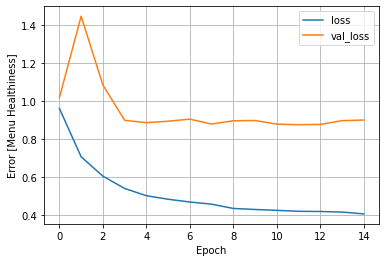

In [ ]:
plot_loss(model_1_history)

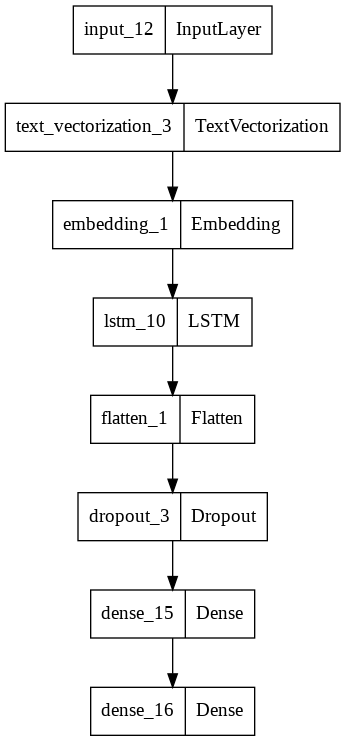

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model_1)

In [ ]:
# Evaluate model on validation data
def model_evaluation(model_name):
  model= tf.keras.models.load_model(f"model_experiments/{model_name}")
  print('results from the training')
  model.evaluate(train_ds_word)
  print('results from the validation set')
  model.evaluate(val_ds_word)
  print('results from the test set')
  model.evaluate(test_ds_word)

In [ ]:
model_evaluation('model_1_LSTM_word')

results from the training
1778/1778 [==============================] - 9s 5ms/step - loss: 0.6555
results from the validation set
85/85 [==============================] - 1s 12ms/step - loss: 0.8765
results from the test set
85/85 [==============================] - 1s 12ms/step - loss: 0.8727


In [ ]:
pd.DataFrame(zip(names_to_predict,model_1.predict(names_to_predict2)),columns=['rest_name','predicted_score'])

,rest_name,predicted_score
0,X's fish & chip shop,[6.843343]
1,Yuru's Pizza & Kebab,[5.6181097]
2,Yuru's Chinese Takeaways,[6.8789444]
3,Yuru's Sushi Takeaways,[8.5164995]
4,Yuru's Sushi Restaurant,[8.7171755]
5,Yuru's Cocktail Bar,[6.4798574]
6,Cambridge Oven,[5.2081327]
7,Yo!Sushi,[6.886839]
8,Starbucks,[7.2835846]
9,Vanderlyle,[6.886839]


## Model 2 (DL): LSTM model, character level tokenization 

### character level tokenization 

In [ ]:
# set up character level tokenization
max_features = 39          # Number of distinct chars 
sequence_length = 57       # Input sequence size

def char_split(input_data):
  return(tf.strings.unicode_split(input_data,'UTF-8'))

vectorize_layer = TextVectorization(
    max_tokens=max_features,
    split=char_split, # word_split or char_split
    output_mode="int",
    output_sequence_length=sequence_length,
)

In [ ]:
batch_size = 32
vectorize_layer.adapt(X_train.batch(batch_size))

In [ ]:
# Average number of characters in the restaurant name 
round(sum([len(tf.strings.unicode_split(i,"UTF-8")) for i in X_train])/len(X_train))

16

In [ ]:
# Maximum number of characters in the restaurant name 
max([len(tf.strings.unicode_split(i,"UTF-8")) for i in X_train])

In [ ]:
def vectorize_text(text):
  text = tf.expand_dims(text, -1)
  return tf.squeeze(vectorize_layer(text))

In [ ]:
vectorize_text('Yuru chinese best')

<tf.Tensor: shape=(57,), dtype=int64, numpy=
array([23, 10,  9, 10,  2, 13, 12,  4,  6,  8,  5,  8,  2, 20,  8,  5,  7,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0])>

In [ ]:
# vectorize the training and test set for building the model
X_train_char = X_train.map(vectorize_text)
X_val_char = X_val.map(vectorize_text)
X_test_char = X_test.map(vectorize_text)

In [ ]:
train_ds_char =  tf.data.Dataset.zip((X_train_char,y_train))
AUTOTUNE = tf.data.AUTOTUNE
train_ds_char = train_ds_char.shuffle(buffer_size=512).batch(batch_size, drop_remainder=True).cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
val_ds_char =  tf.data.Dataset.zip((X_val_char,y_val))
val_ds_char = val_ds_char.shuffle(buffer_size=512).batch(batch_size, drop_remainder=True).cache().prefetch(buffer_size=AUTOTUNE)
test_ds_char =  tf.data.Dataset.zip((X_test_char,y_val))
test_ds_char = test_ds_char.shuffle(buffer_size=512).batch(batch_size, drop_remainder=True).cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)

inputs = tf.keras.Input(shape=(sequence_length), dtype="int64")

x = layers.Embedding(max_features,output_dim=64,embeddings_initializer="uniform",
                                     name="embedding_2")(inputs)

x = layers.LSTM(64, return_sequences=True)(x)
x = layers.Flatten()(x)
x = tf.keras.layers.Dropout(.2)(x)
#x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
# x = layers.Dense(64, activation="relu")(x) 
outputs = layers.Dense(1)(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM_char")
model_2.summary()

Model: "model_2_LSTM_char"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 57)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 57, 64)            2496      
                                                                 
 lstm_14 (LSTM)              (None, 57, 64)            33024     
                                                                 
 flatten_12 (Flatten)        (None, 3648)              0         
                                                                 
 dropout_11 (Dropout)        (None, 3648)              0         
                                                                 
 dense_28 (Dense)            (None, 1)                 3649      
                                                                 
Total params: 39,169
Trainable params: 39,169
Non

In [ ]:
model_2.compile(loss="mean_absolute_error",
                optimizer=tf.keras.optimizers.Adam())
model_2_history = model_2.fit(train_ds, epochs=25, validation_data =val_ds,
                              callbacks=[create_model_checkpoint(model_name=model_2.name),early_stopping])

Epoch 1/25
1773/1778 [============================>.] - ETA: 0s - loss: 0.9728

INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM_char/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_LSTM_char/assets


1778/1778 [==============================] - 18s 9ms/step - loss: 0.9720 - val_loss: 1.3695
Epoch 2/25
1778/1778 [==============================] - 13s 7ms/step - loss: 0.8683 - val_loss: 1.4471
Epoch 3/25
1778/1778 [==============================] - 10s 6ms/step - loss: 0.8528 - val_loss: 1.5959
Epoch 4/25
1777/1778 [============================>.] - ETA: 0s - loss: 0.8465

KeyboardInterrupt: ignored

In [ ]:
plot_loss(model_2_history)

In [ ]:
model_2 = tf.keras.models.load_model("model_experiments/model_2_LSTM_char")                                                                                                                                                                                                         

In [ ]:
model_2.evaluate(train_ds)

In [ ]:
model_2.evaluate(val_ds)

##Model 3(DL): GRU, word level 

Another popular and effective RNN component is the GRU or gated recurrent unit.The GRU cell has similar features to an LSTM cell but has less parameters.

In [ ]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
model_3_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=64,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_3")

# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = word_vectorizer(inputs)
x = model_3_embedding(x)
x= layers.GRU(64)(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.2)(x)
# x = layers.GRU(64, return_sequences=True) # stacking recurrent cells requires return_sequences=True
# x = layers.Dense(64, activation="relu")(x) # optional dense layer after GRU cell
outputs = layers.Dense(1)(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU_word")

In [ ]:
model_3.compile(loss="mean_absolute_error",
                optimizer=tf.keras.optimizers.Adam())
model_3_history = model_3.fit(train_ds_word, epochs=25, validation_data = val_ds_word,
                              callbacks=[create_model_checkpoint(model_name=model_3.name), early_stopping])

In [ ]:
plot_loss(model_3_history)

In [ ]:
model_evaluation("model_3_GRU_word")

In [ ]:
pd.DataFrame(zip(names_to_predict,model_3.predict(names_to_predict2)),columns=['rest_name','predicted_score'])

## Model 4 (DL): GRU, character level 

In [ ]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)

inputs = tf.keras.Input(shape=(sequence_length), dtype="int64")

x = layers.Embedding(max_features,output_dim=64,embeddings_initializer="uniform",
                                     name="embedding_4")(inputs)

x = layers.GRU(64, return_sequences=True)(x)
x = layers.Flatten()(x)
x= layers.Dropout(0.2)(x)
#x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(1)(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_GRU_char")
model_4.summary()

Model: "model_4_GRU_char"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 57)]              0         
                                                                 
 embedding_4 (Embedding)     (None, 57, 64)            2496      
                                                                 
 gru_7 (GRU)                 (None, 57, 64)            24960     
                                                                 
 flatten_13 (Flatten)        (None, 3648)              0         
                                                                 
 dropout_12 (Dropout)        (None, 3648)              0         
                                                                 
 dense_29 (Dense)            (None, 1)                 3649      
                                                                 
Total params: 31,105
Trainable params: 31,105
Non-

In [ ]:
model_4.compile(loss="mean_absolute_error",
                optimizer=tf.keras.optimizers.Adam(),
                metrics = ['mae'])

model_4_history = model_4.fit(train_ds, epochs=25, validation_data = val_ds,
                              callbacks=[create_model_checkpoint(model_name=model_4.name), early_stopping])

Epoch 1/25
1775/1778 [============================>.] - ETA: 0s - loss: 0.9630 - mae: 0.9630

INFO:tensorflow:Assets written to: model_experiments/model_4_GRU_char/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_GRU_char/assets


1778/1778 [==============================] - 17s 9ms/step - loss: 0.9625 - mae: 0.9625 - val_loss: 1.1828 - val_mae: 1.1828
Epoch 2/25
1777/1778 [============================>.] - ETA: 0s - loss: 0.8549 - mae: 0.8549

INFO:tensorflow:Assets written to: model_experiments/model_4_GRU_char/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_GRU_char/assets


1778/1778 [==============================] - 12s 7ms/step - loss: 0.8547 - mae: 0.8547 - val_loss: 1.0982 - val_mae: 1.0982
Epoch 3/25
1768/1778 [============================>.] - ETA: 0s - loss: 0.8268 - mae: 0.8268

INFO:tensorflow:Assets written to: model_experiments/model_4_GRU_char/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_GRU_char/assets


1778/1778 [==============================] - 13s 7ms/step - loss: 0.8262 - mae: 0.8262 - val_loss: 1.0635 - val_mae: 1.0635
Epoch 4/25
1776/1778 [============================>.] - ETA: 0s - loss: 0.8047 - mae: 0.8047

INFO:tensorflow:Assets written to: model_experiments/model_4_GRU_char/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_GRU_char/assets


1778/1778 [==============================] - 12s 7ms/step - loss: 0.8045 - mae: 0.8045 - val_loss: 1.0632 - val_mae: 1.0632
Epoch 5/25
1771/1778 [============================>.] - ETA: 0s - loss: 0.7842 - mae: 0.7842

INFO:tensorflow:Assets written to: model_experiments/model_4_GRU_char/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_GRU_char/assets


1778/1778 [==============================] - 13s 7ms/step - loss: 0.7839 - mae: 0.7839 - val_loss: 1.0542 - val_mae: 1.0542
Epoch 6/25
1775/1778 [============================>.] - ETA: 0s - loss: 0.7659 - mae: 0.7659

INFO:tensorflow:Assets written to: model_experiments/model_4_GRU_char/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_GRU_char/assets


1778/1778 [==============================] - 13s 7ms/step - loss: 0.7658 - mae: 0.7658 - val_loss: 1.0203 - val_mae: 1.0203
Epoch 7/25
1768/1778 [============================>.] - ETA: 0s - loss: 0.7496 - mae: 0.7496

INFO:tensorflow:Assets written to: model_experiments/model_4_GRU_char/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_GRU_char/assets


1778/1778 [==============================] - 13s 7ms/step - loss: 0.7493 - mae: 0.7493 - val_loss: 0.9919 - val_mae: 0.9919
Epoch 8/25
1772/1778 [============================>.] - ETA: 0s - loss: 0.7383 - mae: 0.7383

INFO:tensorflow:Assets written to: model_experiments/model_4_GRU_char/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_GRU_char/assets


1778/1778 [==============================] - 12s 7ms/step - loss: 0.7383 - mae: 0.7383 - val_loss: 0.9792 - val_mae: 0.9792
Epoch 9/25
1777/1778 [============================>.] - ETA: 0s - loss: 0.7268 - mae: 0.7268

INFO:tensorflow:Assets written to: model_experiments/model_4_GRU_char/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_GRU_char/assets


1778/1778 [==============================] - 13s 7ms/step - loss: 0.7267 - mae: 0.7267 - val_loss: 0.9695 - val_mae: 0.9695
Epoch 10/25
1774/1778 [============================>.] - ETA: 0s - loss: 0.7153 - mae: 0.7153

INFO:tensorflow:Assets written to: model_experiments/model_4_GRU_char/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_GRU_char/assets


1778/1778 [==============================] - 12s 7ms/step - loss: 0.7152 - mae: 0.7152 - val_loss: 0.9581 - val_mae: 0.9581
Epoch 11/25
1778/1778 [==============================] - 9s 5ms/step - loss: 0.7096 - mae: 0.7096 - val_loss: 0.9773 - val_mae: 0.9773
Epoch 12/25
1778/1778 [==============================] - 9s 5ms/step - loss: 0.7009 - mae: 0.7009 - val_loss: 0.9603 - val_mae: 0.9603
Epoch 13/25
1775/1778 [============================>.] - ETA: 0s - loss: 0.6946 - mae: 0.6946

INFO:tensorflow:Assets written to: model_experiments/model_4_GRU_char/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_GRU_char/assets


1778/1778 [==============================] - 12s 7ms/step - loss: 0.6947 - mae: 0.6947 - val_loss: 0.9462 - val_mae: 0.9462
Epoch 14/25
1778/1778 [==============================] - 9s 5ms/step - loss: 0.6880 - mae: 0.6880 - val_loss: 0.9780 - val_mae: 0.9780
Epoch 15/25
1770/1778 [============================>.] - ETA: 0s - loss: 0.6801 - mae: 0.6801

INFO:tensorflow:Assets written to: model_experiments/model_4_GRU_char/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_GRU_char/assets


1778/1778 [==============================] - 13s 7ms/step - loss: 0.6802 - mae: 0.6802 - val_loss: 0.9446 - val_mae: 0.9446
Epoch 16/25
1778/1778 [==============================] - 9s 5ms/step - loss: 0.6750 - mae: 0.6750 - val_loss: 0.9489 - val_mae: 0.9489
Epoch 17/25
1778/1778 [==============================] - ETA: 0s - loss: 0.6694 - mae: 0.6694

INFO:tensorflow:Assets written to: model_experiments/model_4_GRU_char/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_GRU_char/assets


1778/1778 [==============================] - 12s 7ms/step - loss: 0.6694 - mae: 0.6694 - val_loss: 0.9372 - val_mae: 0.9372
Epoch 18/25
1778/1778 [==============================] - 9s 5ms/step - loss: 0.6651 - mae: 0.6651 - val_loss: 0.9671 - val_mae: 0.9671
Epoch 19/25
1778/1778 [==============================] - 9s 5ms/step - loss: 0.6586 - mae: 0.6586 - val_loss: 0.9576 - val_mae: 0.9576
Epoch 20/25
1772/1778 [============================>.] - ETA: 0s - loss: 0.6544 - mae: 0.6544

INFO:tensorflow:Assets written to: model_experiments/model_4_GRU_char/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_GRU_char/assets


1778/1778 [==============================] - 12s 7ms/step - loss: 0.6546 - mae: 0.6546 - val_loss: 0.9154 - val_mae: 0.9154
Epoch 21/25
1770/1778 [============================>.] - ETA: 0s - loss: 0.6472 - mae: 0.6472

INFO:tensorflow:Assets written to: model_experiments/model_4_GRU_char/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_GRU_char/assets


1778/1778 [==============================] - 12s 7ms/step - loss: 0.6474 - mae: 0.6474 - val_loss: 0.9112 - val_mae: 0.9112
Epoch 22/25
1778/1778 [==============================] - 9s 5ms/step - loss: 0.6453 - mae: 0.6453 - val_loss: 0.9200 - val_mae: 0.9200
Epoch 23/25
1778/1778 [==============================] - 9s 5ms/step - loss: 0.6398 - mae: 0.6398 - val_loss: 0.9463 - val_mae: 0.9463
Epoch 24/25
1778/1778 [==============================] - 9s 5ms/step - loss: 0.6362 - mae: 0.6362 - val_loss: 0.9368 - val_mae: 0.9368


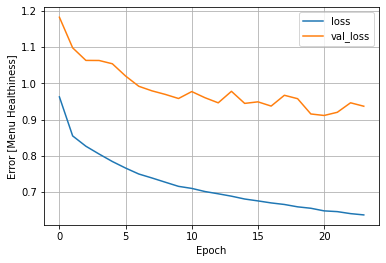

In [ ]:
plot_loss(model_4_history)

In [ ]:
model_4 = tf.keras.models.load_model("model_experiments/model_4_GRU_char")
model_4.evaluate(val_ds)
model_4.evaluate(train_ds)

1778/1778 [==============================] - 5s 3ms/step - loss: 0.8183 - mae: 0.8183


[0.8183445334434509, 0.8183445334434509]



## Model 5 (DL): CNN, word level 

In [ ]:
# Set random seed and create embedding layer (new embedding layer for each model)
model_5_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=64,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_5")

inputs = layers.Input(shape=(1,), dtype="string")
x = word_vectorizer(inputs)
x = model_5_embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
x= layers.Dropout(0.2)(x)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer
outputs = layers.Dense(1)(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D_word")

In [ ]:
model_5.compile(loss="mean_absolute_error",
                optimizer=tf.keras.optimizers.Adam())
model_5_history = model_5.fit(train_ds_word, epochs=25, validation_data =val_ds_word,
                              callbacks=[create_model_checkpoint(model_name=model_5.name), early_stopping])

Epoch 1/25
1778/1778 [==============================] - ETA: 0s - loss: 1.3069INFO:tensorflow:Assets written to: model_experiments/model_5_Conv1D_word/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_Conv1D_word/assets


1778/1778 [==============================] - 10s 5ms/step - loss: 1.3069 - val_loss: 1.2526
Epoch 2/25
1771/1778 [============================>.] - ETA: 0s - loss: 0.9912INFO:tensorflow:Assets written to: model_experiments/model_5_Conv1D_word/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_Conv1D_word/assets


1778/1778 [==============================] - 7s 4ms/step - loss: 0.9906 - val_loss: 1.0690
Epoch 3/25
1775/1778 [============================>.] - ETA: 0s - loss: 0.9129INFO:tensorflow:Assets written to: model_experiments/model_5_Conv1D_word/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_Conv1D_word/assets


1778/1778 [==============================] - 7s 4ms/step - loss: 0.9125 - val_loss: 1.0165
Epoch 4/25
1772/1778 [============================>.] - ETA: 0s - loss: 0.8387INFO:tensorflow:Assets written to: model_experiments/model_5_Conv1D_word/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_Conv1D_word/assets


1778/1778 [==============================] - 10s 5ms/step - loss: 0.8387 - val_loss: 0.9764
Epoch 5/25
1771/1778 [============================>.] - ETA: 0s - loss: 0.7825INFO:tensorflow:Assets written to: model_experiments/model_5_Conv1D_word/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_Conv1D_word/assets


1778/1778 [==============================] - 12s 6ms/step - loss: 0.7824 - val_loss: 0.9644
Epoch 6/25
1778/1778 [==============================] - 11s 6ms/step - loss: 0.7349 - val_loss: 1.0064
Epoch 7/25
1778/1778 [==============================] - 6s 4ms/step - loss: 0.7075 - val_loss: 1.0013
Epoch 8/25
1778/1778 [==============================] - 7s 4ms/step - loss: 0.6380 - val_loss: 0.9878


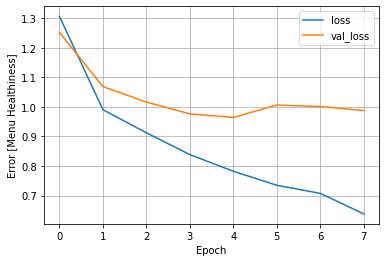

In [ ]:
plot_loss(model_5_history)

In [ ]:
model_evaluation("model_5_Conv1D_word")

results from the training
1778/1778 [==============================] - 4s 2ms/step - loss: 0.7364
results from the validation set
85/85 [==============================] - 0s 2ms/step - loss: 0.9644
results from the test set
85/85 [==============================] - 0s 2ms/step - loss: 0.9665


## Model 6: CNN character level

In [ ]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)

inputs = tf.keras.Input(shape=(sequence_length), dtype="int64")

x = layers.Embedding(max_features,output_dim=64,embeddings_initializer="uniform",
                                     name="embedding_6")(inputs)

x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
x = layers.Dropout(0.2)(x)
#x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(1)(x)
model_6 = tf.keras.Model(inputs, outputs, name="model_6_CNN_char")
model_6.summary()

Model: "model_6_CNN_char"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 57)]              0         
                                                                 
 embedding_6 (Embedding)     (None, 57, 64)            2496      
                                                                 
 conv1d_2 (Conv1D)           (None, 53, 32)            10272     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_14 (Dropout)        (None, 32)                0         
                                                                 
 dense_32 (Dense)            (None, 1)                 33        
                                                  

In [ ]:
model_6.compile(loss="mean_absolute_error",
                optimizer=tf.keras.optimizers.Adam())
model_6_history = model_6.fit(train_ds, epochs=25, validation_data = val_ds,
                              callbacks=[create_model_checkpoint(model_name=model_6.name), early_stopping])

Epoch 1/25
1777/1778 [============================>.] - ETA: 0s - loss: 1.3928INFO:tensorflow:Assets written to: model_experiments/model_6_CNN_char/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_CNN_char/assets


1778/1778 [==============================] - 6s 3ms/step - loss: 1.3924 - val_loss: 1.4018
Epoch 2/25
1768/1778 [============================>.] - ETA: 0s - loss: 1.1142INFO:tensorflow:Assets written to: model_experiments/model_6_CNN_char/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_CNN_char/assets


1778/1778 [==============================] - 6s 3ms/step - loss: 1.1124 - val_loss: 1.2432
Epoch 3/25
1778/1778 [==============================] - 5s 3ms/step - loss: 1.0622 - val_loss: 1.3555
Epoch 4/25
1773/1778 [============================>.] - ETA: 0s - loss: 1.0194INFO:tensorflow:Assets written to: model_experiments/model_6_CNN_char/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_CNN_char/assets


1778/1778 [==============================] - 6s 3ms/step - loss: 1.0186 - val_loss: 1.0957
Epoch 5/25
1778/1778 [==============================] - 5s 3ms/step - loss: 0.9963 - val_loss: 1.1292
Epoch 6/25
1766/1778 [============================>.] - ETA: 0s - loss: 1.0967INFO:tensorflow:Assets written to: model_experiments/model_6_CNN_char/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_CNN_char/assets


1778/1778 [==============================] - 6s 3ms/step - loss: 1.0963 - val_loss: 0.9875
Epoch 7/25
1770/1778 [============================>.] - ETA: 0s - loss: 0.9928INFO:tensorflow:Assets written to: model_experiments/model_6_CNN_char/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_CNN_char/assets


1778/1778 [==============================] - 6s 3ms/step - loss: 0.9919 - val_loss: 0.9500
Epoch 8/25
1778/1778 [==============================] - 5s 3ms/step - loss: 0.8789 - val_loss: 0.9672
Epoch 9/25
1767/1778 [============================>.] - ETA: 0s - loss: 0.9275INFO:tensorflow:Assets written to: model_experiments/model_6_CNN_char/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_CNN_char/assets


1778/1778 [==============================] - 6s 4ms/step - loss: 0.9259 - val_loss: 0.9336
Epoch 10/25
1778/1778 [==============================] - 5s 3ms/step - loss: 0.8974 - val_loss: 0.9411
Epoch 11/25
1778/1778 [==============================] - 5s 3ms/step - loss: 0.9157 - val_loss: 0.9563
Epoch 12/25
1778/1778 [==============================] - 5s 3ms/step - loss: 0.9103 - val_loss: 0.9419


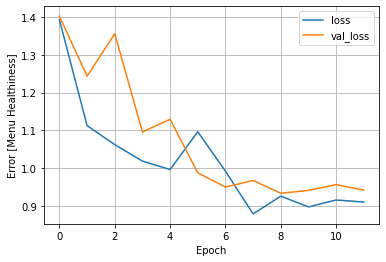

In [ ]:
plot_loss(model_6_history)

In [ ]:
model_6 = tf.keras.models.load_model("model_experiments/model_6_CNN_char")
model_6.evaluate(val_ds)
model_6.evaluate(train_ds)

1778/1778 [==============================] - 3s 2ms/step - loss: 0.8879


0.8879064321517944

## Model 7 (DL): Transfer learning ULM 

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [ ]:
def train_step(*, model, ulmfit, loss_fn, optimizer, x, y):
    ulmfit.apply_awd(0.5)
    with tf.GradientTape() as tape:
        y_preds = model(x, training=True)
        loss_value = loss_fn(y_true=y, y_pred=y_preds)
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [ ]:
class AWDCallback(tf.keras.callbacks.Callback):
    def __init__(self, *, ulmfit, awd_rate=0.5):
        super().__init__()
        self.ulmfit = ulmfit

    def on_train_batch_begin(self, batch, logs=None):
        self.ulmfit.apply_awd(self.awd_rate)

In [ ]:
ulmfit = hub.load('https://tfhub.dev/edrone/ulmfit/en/sp35k_uncased/1')
encoder = hub.KerasLayer(ulmfit.signatures['string_encoder'], trainable= True, name = "universal_language_model")

In [ ]:
input_layer = tf.keras.layers.Input(shape=(), dtype=tf.string)
enc_out = encoder(input_layer) # the output is a dict of tensors with keys 'output_rows' and 'output_flat'
enc_out_ragged = tf.RaggedTensor.from_row_splits(enc_out['output_flat'],   # converting to RaggedTensor
                                                 enc_out['output_rows'])
vector_average = tf.reduce_mean(enc_out_ragged, axis=1) # rather than use the last hidden state, we take the average
                                                        # value of each dimension in a sequence
dense = tf.keras.layers.Dense(64, activation='relu')(vector_average)
dense = tf.keras.layers.Dense(64,activation="relu")(dense)
dense = tf.keras.layers.Dense(1)(dense)
model_7 = tf.keras.models.Model(inputs=encoder.input, outputs=dense,name="Model_7_ulmfit")
model_7.summary()

In [ ]:
model_7.compile(loss="mean_absolute_error",
                optimizer=tf.keras.optimizers.Adam())

model_7_history = model_7.fit(x=X_train, y=y_train, epochs=25,validation_data=(X_val, y_val),
                              callbacks=[model_check_point('Model_7_ULMFit_word'),early_stopping])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/model_2/AWD_RNN1/RaggedToTensor/RaggedTensorToTensor_grad/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradients/model_2/AWD_RNN1/RaggedToTensor/RaggedTensorToTensor_grad/boolean_mask/GatherV2:0", shape=(None, 400), dtype=float32), dense_shape=Tensor("gradients/model_2/AWD_RNN1/RaggedToTensor/RaggedTensorToTensor_grad/Shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


1311/1311 [==============================] - 184s 138ms/step - loss: 1.0943 - val_loss: 0.8200
Epoch 2/100
1311/1311 [==============================] - 181s 138ms/step - loss: 0.7766 - val_loss: 0.8400
Epoch 3/100
1311/1311 [==============================] - 179s 137ms/step - loss: 0.6984 - val_loss: 0.8308
Epoch 4/100
1311/1311 [==============================] - 177s 135ms/step - loss: 0.6291 - val_loss: 0.7955
Epoch 5/100
1311/1311 [==============================] - 177s 135ms/step - loss: 0.5766 - val_loss: 0.8149
Epoch 6/100
1311/1311 [==============================] - 178s 136ms/step - loss: 0.5324 - val_loss: 0.8307
Epoch 7/100
1311/1311 [==============================] - 178s 136ms/step - loss: 0.4848 - val_loss: 0.8347
Epoch 8/100
1311/1311 [==============================] - 176s 134ms/step - loss: 0.4524 - val_loss: 0.8318
Epoch 9/100
1311/1311 [==============================] - 175s 133ms/step - loss: 0.4123 - val_loss: 0.8481


In [ ]:
model_7.evaluate(X_test,y_test)

73/73 [==============================] - 2s 28ms/step - loss: 0.8006


0.8005802631378174

## Model 8 (DL): Adding hygine ratings 

In [ ]:
#prepare the data 
ratings = pd.read_csv('ratings.csv')
ratings.head()

,Unnamed: 0,0
0,0,Pass
1,1,NaN
2,2,Pass
3,3,NaN
4,4,Improvement Required


In [ ]:
justeat_menu['hg'] = ratings.iloc[:,1]

In [ ]:
# focus on England only: restaurants with hyginene ratings
justeat_hr = justeat_menu[justeat_menu['hg'].notnull()]
justeat_eng = justeat_hr[justeat_hr['hg'].str.contains('0|1|2|3|4|5')]
justeat_eng['hg_rating'] = justeat_eng.hg.astype("float64")
justeat_eng['rest_name'] = justeat_eng.rest_name.astype("string")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
justeat_eng.head()

,Restaurant ID,Desserts,Vegetables,Salads,Chips,Water,Milk,Special Offers,rest_name,address,...,review,specialOffers,chips,salads,predict,rating2,ascii_name_fix,hyginene,hg,hg_rating
318,138434,0,15,0,1,0,0,0,Amrit Indian Restaurant,"80 St. Peter's Street St. Albans, Hertfordshir...",...,NaN,0,1,0,8.229810,3,amrit indian restaurant,5,5,1.0
319,31957,11,12,3,3,0,0,19,Farmhouse Pizza,"3a Shenley Lane, London Colney, St Albans, AL2...",...,NaN,10,3,3,6.319548,1,farmhouse pizza,4,4,0.8
320,66311,0,13,2,1,0,0,4,India Garden,"24 Catherine Street, St Albans, AL3 5BX",...,NaN,4,1,2,7.797340,2,india garden,5,5,1.0
321,131155,13,17,7,2,2,0,1,Nonnos Pizza,"1 Church View, Church Street St. Albans, Hertf...",...,NaN,1,2,7,9.000784,3,nonnos pizza,4,4,0.8
322,42434,14,26,0,3,0,0,2,Paya,"4 Harding Parade Station Road, Harpenden, AL5 4SW",...,NaN,2,3,0,8.354105,3,paya,4,4,0.8


In [ ]:
# Train test split 

# Use train_test_split to split training data into training and test sets
X_train_hg,X_test_hg_, y_train_hg, y_test_ = train_test_split(justeat_eng[["rest_name",'hg_rating']],
                                                                            justeat_eng["predict"],
                                                                            test_size=0.1, # dedicate 10% of samples to test set
                                                                            random_state=42) # random state for repr

In [ ]:
# Train validation Split 
X_test_hg, X_val_hg, y_test_hg, y_val_hg = train_test_split(X_test_hg_, y_test_,test_size=0.5, random_state=42)

In [ ]:
X_train_hg.shape, X_test_hg.shape, X_val_hg.shape

((38483, 2), (2138, 2), (2138, 2))

word vectorization

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
# Setup text vectorization with custom variables
max_vocab_length=20000
max_length = 10 # max length our sequences will be (e.g. how many words from the restaurant name does our model see?)

word_vectorizer = TextVectorization(output_mode="int",
                                    max_tokens = max_vocab_length,
                                    split = "whitespace",
                                    standardize ="lower_and_strip_punctuation",
                                    output_sequence_length=max_length)
word_vectorizer.adapt(X_train_hg['rest_name'])

In [ ]:
from collections import Counter
Counter(X_train_hg['hg_rating'])

Counter({0.0: 53, 0.2: 901, 0.4: 1082, 0.6: 6080, 0.8: 9096, 1.0: 21271})

In [ ]:
X_train_hg

,rest_name,hg_rating
44029,Goldthorpe Grill,0.6
38447,McDonald's® - Norwich Airport,1.0
43544,Shaan Indian Takeaway,0.6
2739,Home Grill,0.4
41102,Perfect Pizza,0.8
...,...,...
8127,Browns Fish & Chips,1.0
14074,Sinfin Fish Bar,0.8
49344,McDonald's® - Fulham,1.0
1563,Subway® - Coventry Road,1.0


In [ ]:
#import tensorflow as tf
#from tensorflow.keras import layers

# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)

nlp_input = tf.keras.Input(shape=(10,), name='nlp_input')
#nlp_token = word_vectorizer(nlp_input)
hygiene_input = tf.keras.Input(shape=(1,), name='hygiene_input')
#hygiene_out = layers.Dense(64, activation = 'relu')(hygiene_input)
emb = layers.Embedding(output_dim=64, input_dim=max_vocab_length, input_length=max_length)(nlp_input)
nlp_out = layers.GRU(64)(emb)
x = tf.concat([nlp_out, hygiene_input],1)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(1)(x)
model_8 = tf.keras.Model(inputs=[nlp_input , hygiene_input], outputs=[x],name ='Model_8_hr_word_GRU')

In [ ]:
model_8.compile(loss="mean_absolute_error",
                optimizer=tf.keras.optimizers.Adam())

model_8.summary()

Model: "Model_8_hr_word_GRU"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 nlp_input (InputLayer)         [(None, 10)]         0           []                               
                                                                                                  
 embedding_9 (Embedding)        (None, 10, 64)       1280000     ['nlp_input[0][0]']              
                                                                                                  
 gru_9 (GRU)                    (None, 64)           24960       ['embedding_9[0][0]']            
                                                                                                  
 hygiene_input (InputLayer)     [(None, 1)]          0           []                               
                                                                                

In [ ]:
X_train_hg_name = word_vectorizer(tf.convert_to_tensor(X_train_hg['rest_name'].values))
print(X_train_hg_name.shape)

X_val_hg_name = word_vectorizer(tf.convert_to_tensor(X_val_hg['rest_name'].values))
print(X_val_hg_name.shape)

X_test_hg_name = word_vectorizer(tf.convert_to_tensor(X_test_hg['rest_name'].values))
print(X_test_hg_name.shape)

(38483, 10)
(2138, 10)
(2138, 10)


In [ ]:
X_train_hg_hg = X_train_hg['hg_rating'].values
print(X_train_hg_hg.shape)

X_val_hg_hg = X_val_hg['hg_rating'].values
print(X_val_hg_hg.shape)


X_test_hg_hg = X_test_hg['hg_rating'].values
print(X_test_hg_hg.shape)

(38483,)
(2138,)
(2138,)


In [ ]:
model_8_history = model_8.fit([X_train_hg_name,X_train_hg_hg], y_train_hg, epochs=25,
                              validation_data = ([X_val_hg_name,X_val_hg_hg], y_val_hg),
                              callbacks=[create_model_checkpoint(model_name=model_8.name)])

Epoch 1/25
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1197/1203 [============================>.] - ETA: 0s - loss: 1.0618WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fe5cf3194d0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x7fe5ce940a90>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x7fe5ce940a90>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x7fe5ce940a90>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:tensorflow:Assets written to: model_experiments/Model_8_hr_word_GRU/assets


INFO:tensorflow:Assets written to: model_experiments/Model_8_hr_word_GRU/assets


1203/1203 [==============================] - 12s 8ms/step - loss: 1.0613 - val_loss: 0.9654
Epoch 2/25
1197/1203 [============================>.] - ETA: 0s - loss: 0.7887WARNING:tensorflow:AutoGraph could not transform <function canonicalize_signatures.<locals>.signature_wrapper at 0x7fe5ce6d5b90> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x7fe5ce940a50>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x7fe5ce940a50>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x7fe5ce940a50>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:tensorflow:Assets written to: model_experiments/Model_8_hr_word_GRU/assets


INFO:tensorflow:Assets written to: model_experiments/Model_8_hr_word_GRU/assets


1203/1203 [==============================] - 10s 8ms/step - loss: 0.7883 - val_loss: 0.8640
Epoch 3/25
1200/1203 [============================>.] - ETA: 0s - loss: 0.6935WARNING:tensorflow:AutoGraph could not transform <function canonicalize_signatures.<locals>.signature_wrapper at 0x7fe59c587f80> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x7fe58529af50>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x7fe58529af50>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x7fe58529af50>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:tensorflow:Assets written to: model_experiments/Model_8_hr_word_GRU/assets


INFO:tensorflow:Assets written to: model_experiments/Model_8_hr_word_GRU/assets


1203/1203 [==============================] - 10s 8ms/step - loss: 0.6938 - val_loss: 0.8611
Epoch 4/25
1202/1203 [============================>.] - ETA: 0s - loss: 0.6271WARNING:tensorflow:AutoGraph could not transform <function canonicalize_signatures.<locals>.signature_wrapper at 0x7fe5850d5b90> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x7fe59c644b10>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x7fe59c644b10>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x7fe59c644b10>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:tensorflow:Assets written to: model_experiments/Model_8_hr_word_GRU/assets


INFO:tensorflow:Assets written to: model_experiments/Model_8_hr_word_GRU/assets


1203/1203 [==============================] - 10s 8ms/step - loss: 0.6271 - val_loss: 0.8395
Epoch 5/25
1193/1203 [============================>.] - ETA: 0s - loss: 0.5824WARNING:tensorflow:AutoGraph could not transform <function canonicalize_signatures.<locals>.signature_wrapper at 0x7fe5e16e7680> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x7fe5b8792fd0>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x7fe5b8792fd0>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x7fe5b8792fd0>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:tensorflow:Assets written to: model_experiments/Model_8_hr_word_GRU/assets


INFO:tensorflow:Assets written to: model_experiments/Model_8_hr_word_GRU/assets


1203/1203 [==============================] - 10s 8ms/step - loss: 0.5827 - val_loss: 0.8365
Epoch 6/25
1203/1203 [==============================] - 6s 5ms/step - loss: 0.5522 - val_loss: 0.8393
Epoch 7/25
1203/1203 [==============================] - 6s 5ms/step - loss: 0.5290 - val_loss: 0.8400
Epoch 8/25
1203/1203 [==============================] - 6s 5ms/step - loss: 0.5102 - val_loss: 0.8426
Epoch 9/25
1203/1203 [==============================] - 6s 5ms/step - loss: 0.4937 - val_loss: 0.8444
Epoch 10/25
1203/1203 [==============================] - 6s 5ms/step - loss: 0.4796 - val_loss: 0.8416
Epoch 11/25
1203/1203 [==============================] - 6s 5ms/step - loss: 0.4678 - val_loss: 0.8602
Epoch 12/25
1203/1203 [==============================] - 6s 5ms/step - loss: 0.4552 - val_loss: 0.8513
Epoch 13/25
1203/1203 [==============================] - 7s 6ms/step - loss: 0.4437 - val_loss: 0.8498
Epoch 14/25
1203/1203 [==============================] - 10s 8ms/step - loss: 0.4329 - v

In [ ]:
# load the best performing model and then evaluate the performance
model_8 = tf.keras.models.load_model("/content/model_experiments/Model_8_hr_word_GRU")

In [ ]:
model_8.evaluate([X_train_hg_name,X_train_hg_hg], y_train_hg)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1203/1203 [==============================] - 5s 4ms/step - loss: 0.5217


0.5217203497886658

In [ ]:
model_8.evaluate([X_test_hg_name,X_test_hg_hg], y_test_hg)

67/67 [==============================] - 0s 4ms/step - loss: 0.8765


0.8765104413032532

## Model 9: add hygiene rating, character level GRU 

In [ ]:
# set up character level tokenization
max_features = 39          # Number of distinct chars 
sequence_length = 57       # Input sequence size

def char_split(input_data):
  return(tf.strings.unicode_split(input_data,'UTF-8'))

vectorize_layer = TextVectorization(
    max_tokens=max_features,
    split=char_split, # word_split or char_split
    output_mode="int",
    output_sequence_length=sequence_length,
)

In [ ]:
vectorize_layer.adapt(X_train_hg.rest_name)

In [ ]:
X_train_hg_name_char = vectorize_layer(tf.convert_to_tensor(X_train_hg['rest_name'].values))
print(X_train_hg_name_char.shape)

X_val_hg_name_char = vectorize_layer(tf.convert_to_tensor(X_val_hg['rest_name'].values))
print(X_val_hg_name_char.shape)

X_test_hg_name_char = vectorize_layer(tf.convert_to_tensor(X_test_hg['rest_name'].values))
print(X_test_hg_name_char.shape)

(38483, 57)
(2138, 57)
(2138, 57)


In [ ]:
nlp_input = tf.keras.Input(shape=(sequence_length,), name='nlp_input')
#nlp_token = word_vectorizer(nlp_input)
hygiene_input = tf.keras.Input(shape=(1,), name='hygiene_input')
#hygiene_out = layers.Dense(64, activation = 'relu')(hygiene_input)
emb = layers.Embedding(output_dim=64, input_dim = max_features)(nlp_input)
nlp_out = layers.GRU(64)(emb)
x = tf.concat([nlp_out, hygiene_input],1)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(1)(x)
model_9 = tf.keras.Model(inputs=[nlp_input , hygiene_input], outputs=[x], name = 'Model_9_hr_char_GRU')

In [ ]:
model_9.compile(loss="mean_absolute_error",
                optimizer=tf.keras.optimizers.Adam(),
                metrics = ['mae','mean_absolute_percentage_error'])

model_9.summary()

Model: "Model_9_hr_char_GRU"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 nlp_input (InputLayer)         [(None, 57)]         0           []                               
                                                                                                  
 embedding_11 (Embedding)       (None, 57, 64)       2496        ['nlp_input[0][0]']              
                                                                                                  
 gru_11 (GRU)                   (None, 64)           24960       ['embedding_11[0][0]']           
                                                                                                  
 hygiene_input (InputLayer)     [(None, 1)]          0           []                               
                                                                                

In [ ]:
model_9_history = model_9.fit([X_train_hg_name_char,X_train_hg.hg_rating], y_train_hg, epochs=25,
                              validation_data = ([X_val_hg_name_char,X_val_hg.hg_rating], y_val_hg),
                              callbacks=[create_model_checkpoint(model_name=model_9.name)])

Epoch 1/25
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1198/1203 [============================>.] - ETA: 0s - loss: 1.2959 - mae: 1.2959 - mean_absolute_percentage_error: 14615386.0000WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fe5b9c56dd0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x7fe5b95528d0>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x7fe5b95528d0>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x7fe5b95528d0>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:tensorflow:Assets written to: model_experiments/Model_9_hr_char_GRU/assets


INFO:tensorflow:Assets written to: model_experiments/Model_9_hr_char_GRU/assets


1203/1203 [==============================] - 29s 21ms/step - loss: 1.2954 - mae: 1.2954 - mean_absolute_percentage_error: 14559557.0000 - val_loss: 1.1839 - val_mae: 1.1839 - val_mean_absolute_percentage_error: 25125782.0000
Epoch 2/25
1203/1203 [==============================] - 12s 10ms/step - loss: 1.1944 - mae: 1.1944 - mean_absolute_percentage_error: 15016494.0000 - val_loss: 1.1919 - val_mae: 1.1919 - val_mean_absolute_percentage_error: 25466450.0000
Epoch 3/25
1201/1203 [============================>.] - ETA: 0s - loss: 1.1381 - mae: 1.1381 - mean_absolute_percentage_error: 14562356.0000WARNING:tensorflow:AutoGraph could not transform <function canonicalize_signatures.<locals>.signature_wrapper at 0x7fe5b95b9440> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x7fe57941c490>
To silence this warn

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x7fe57941c490>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x7fe57941c490>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:tensorflow:Assets written to: model_experiments/Model_9_hr_char_GRU/assets


INFO:tensorflow:Assets written to: model_experiments/Model_9_hr_char_GRU/assets


1203/1203 [==============================] - 19s 16ms/step - loss: 1.1382 - mae: 1.1382 - mean_absolute_percentage_error: 14696048.0000 - val_loss: 1.0630 - val_mae: 1.0630 - val_mean_absolute_percentage_error: 22898294.0000
Epoch 4/25
1198/1203 [============================>.] - ETA: 0s - loss: 1.0183 - mae: 1.0183 - mean_absolute_percentage_error: 14037811.0000WARNING:tensorflow:AutoGraph could not transform <function canonicalize_signatures.<locals>.signature_wrapper at 0x7fe579485710> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x7fe57981ed50>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x7fe57981ed50>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x7fe57981ed50>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:tensorflow:Assets written to: model_experiments/Model_9_hr_char_GRU/assets


INFO:tensorflow:Assets written to: model_experiments/Model_9_hr_char_GRU/assets


1203/1203 [==============================] - 15s 13ms/step - loss: 1.0182 - mae: 1.0182 - mean_absolute_percentage_error: 13984188.0000 - val_loss: 0.9971 - val_mae: 0.9971 - val_mean_absolute_percentage_error: 22853290.0000
Epoch 5/25
1203/1203 [==============================] - ETA: 0s - loss: 0.9813 - mae: 0.9813 - mean_absolute_percentage_error: 13160158.0000WARNING:tensorflow:AutoGraph could not transform <function canonicalize_signatures.<locals>.signature_wrapper at 0x7fe68e1ddc20> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x7fe5d1380610>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x7fe5d1380610>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x7fe5d1380610>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:tensorflow:Assets written to: model_experiments/Model_9_hr_char_GRU/assets


INFO:tensorflow:Assets written to: model_experiments/Model_9_hr_char_GRU/assets


1203/1203 [==============================] - 12s 10ms/step - loss: 0.9813 - mae: 0.9813 - mean_absolute_percentage_error: 13160158.0000 - val_loss: 0.9886 - val_mae: 0.9886 - val_mean_absolute_percentage_error: 22756412.0000
Epoch 6/25
1198/1203 [============================>.] - ETA: 0s - loss: 0.9456 - mae: 0.9456 - mean_absolute_percentage_error: 12323770.0000WARNING:tensorflow:AutoGraph could not transform <function canonicalize_signatures.<locals>.signature_wrapper at 0x7fe5dfd15d40> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x7fe57b830110>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x7fe57b830110>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x7fe57b830110>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:tensorflow:Assets written to: model_experiments/Model_9_hr_char_GRU/assets


INFO:tensorflow:Assets written to: model_experiments/Model_9_hr_char_GRU/assets


1203/1203 [==============================] - 12s 10ms/step - loss: 0.9450 - mae: 0.9450 - mean_absolute_percentage_error: 12276695.0000 - val_loss: 0.9342 - val_mae: 0.9342 - val_mean_absolute_percentage_error: 21104454.0000
Epoch 7/25
1199/1203 [============================>.] - ETA: 0s - loss: 0.9184 - mae: 0.9184 - mean_absolute_percentage_error: 11505397.0000WARNING:tensorflow:AutoGraph could not transform <function canonicalize_signatures.<locals>.signature_wrapper at 0x7fe57b887320> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x7fe57a6a1b10>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x7fe57a6a1b10>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x7fe57a6a1b10>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:tensorflow:Assets written to: model_experiments/Model_9_hr_char_GRU/assets


INFO:tensorflow:Assets written to: model_experiments/Model_9_hr_char_GRU/assets


1203/1203 [==============================] - 12s 10ms/step - loss: 0.9187 - mae: 0.9187 - mean_absolute_percentage_error: 11565528.0000 - val_loss: 0.9212 - val_mae: 0.9212 - val_mean_absolute_percentage_error: 20026516.0000
Epoch 8/25
1196/1203 [============================>.] - ETA: 0s - loss: 0.8960 - mae: 0.8960 - mean_absolute_percentage_error: 11047641.0000WARNING:tensorflow:AutoGraph could not transform <function canonicalize_signatures.<locals>.signature_wrapper at 0x7fe579ccadd0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x7fe5785924d0>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x7fe5785924d0>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x7fe5785924d0>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:tensorflow:Assets written to: model_experiments/Model_9_hr_char_GRU/assets


INFO:tensorflow:Assets written to: model_experiments/Model_9_hr_char_GRU/assets


1203/1203 [==============================] - 12s 10ms/step - loss: 0.8959 - mae: 0.8959 - mean_absolute_percentage_error: 11144276.0000 - val_loss: 0.9077 - val_mae: 0.9077 - val_mean_absolute_percentage_error: 19594774.0000
Epoch 9/25
1203/1203 [==============================] - 8s 7ms/step - loss: 0.8767 - mae: 0.8767 - mean_absolute_percentage_error: 11079621.0000 - val_loss: 0.9161 - val_mae: 0.9161 - val_mean_absolute_percentage_error: 18454932.0000
Epoch 10/25
1203/1203 [==============================] - 8s 7ms/step - loss: 0.8643 - mae: 0.8643 - mean_absolute_percentage_error: 11006585.0000 - val_loss: 0.9145 - val_mae: 0.9145 - val_mean_absolute_percentage_error: 17875006.0000
Epoch 11/25
1202/1203 [============================>.] - ETA: 0s - loss: 0.8513 - mae: 0.8513 - mean_absolute_percentage_error: 10805670.0000WARNING:tensorflow:AutoGraph could not transform <function canonicalize_signatures.<locals>.signature_wrapper at 0x7fe578601680> and will run it as-is.
Please report

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x7fe5dfeb2b10>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x7fe5dfeb2b10>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:tensorflow:Assets written to: model_experiments/Model_9_hr_char_GRU/assets


INFO:tensorflow:Assets written to: model_experiments/Model_9_hr_char_GRU/assets


1203/1203 [==============================] - 13s 11ms/step - loss: 0.8511 - mae: 0.8511 - mean_absolute_percentage_error: 10800335.0000 - val_loss: 0.8833 - val_mae: 0.8833 - val_mean_absolute_percentage_error: 17939522.0000
Epoch 12/25
1197/1203 [============================>.] - ETA: 0s - loss: 0.8403 - mae: 0.8403 - mean_absolute_percentage_error: 10572634.0000WARNING:tensorflow:AutoGraph could not transform <function canonicalize_signatures.<locals>.signature_wrapper at 0x7fe578601680> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x7fe5774f4b50>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x7fe5774f4b50>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x7fe5774f4b50>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:tensorflow:Assets written to: model_experiments/Model_9_hr_char_GRU/assets


INFO:tensorflow:Assets written to: model_experiments/Model_9_hr_char_GRU/assets


1203/1203 [==============================] - 12s 10ms/step - loss: 0.8403 - mae: 0.8403 - mean_absolute_percentage_error: 10523456.0000 - val_loss: 0.8782 - val_mae: 0.8782 - val_mean_absolute_percentage_error: 18733900.0000
Epoch 13/25
1196/1203 [============================>.] - ETA: 0s - loss: 0.8296 - mae: 0.8296 - mean_absolute_percentage_error: 10594087.0000WARNING:tensorflow:AutoGraph could not transform <function canonicalize_signatures.<locals>.signature_wrapper at 0x7fe5d10ffe60> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x7fe576b5f5d0>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x7fe576b5f5d0>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x7fe576b5f5d0>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:tensorflow:Assets written to: model_experiments/Model_9_hr_char_GRU/assets


INFO:tensorflow:Assets written to: model_experiments/Model_9_hr_char_GRU/assets


1203/1203 [==============================] - 12s 10ms/step - loss: 0.8300 - mae: 0.8300 - mean_absolute_percentage_error: 10536000.0000 - val_loss: 0.8738 - val_mae: 0.8738 - val_mean_absolute_percentage_error: 18424184.0000
Epoch 14/25
1203/1203 [==============================] - 8s 7ms/step - loss: 0.8171 - mae: 0.8171 - mean_absolute_percentage_error: 10054184.0000 - val_loss: 0.8997 - val_mae: 0.8997 - val_mean_absolute_percentage_error: 17776614.0000
Epoch 15/25
1203/1203 [==============================] - 8s 7ms/step - loss: 0.8037 - mae: 0.8037 - mean_absolute_percentage_error: 10038728.0000 - val_loss: 0.8784 - val_mae: 0.8784 - val_mean_absolute_percentage_error: 20041742.0000
Epoch 16/25
1199/1203 [============================>.] - ETA: 0s - loss: 0.7940 - mae: 0.7940 - mean_absolute_percentage_error: 10247896.0000WARNING:tensorflow:AutoGraph could not transform <function canonicalize_signatures.<locals>.signature_wrapper at 0x7fe577a2acb0> and will run it as-is.
Please repor

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x7fe57630ff90>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x7fe57630ff90>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:tensorflow:Assets written to: model_experiments/Model_9_hr_char_GRU/assets


INFO:tensorflow:Assets written to: model_experiments/Model_9_hr_char_GRU/assets


1203/1203 [==============================] - 12s 10ms/step - loss: 0.7939 - mae: 0.7939 - mean_absolute_percentage_error: 10217272.0000 - val_loss: 0.8669 - val_mae: 0.8669 - val_mean_absolute_percentage_error: 18365684.0000
Epoch 17/25
1202/1203 [============================>.] - ETA: 0s - loss: 0.7852 - mae: 0.7852 - mean_absolute_percentage_error: 9888292.0000WARNING:tensorflow:AutoGraph could not transform <function canonicalize_signatures.<locals>.signature_wrapper at 0x7fe577c1c170> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x7fe5758c2950>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x7fe5758c2950>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x7fe5758c2950>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:tensorflow:Assets written to: model_experiments/Model_9_hr_char_GRU/assets


INFO:tensorflow:Assets written to: model_experiments/Model_9_hr_char_GRU/assets


1203/1203 [==============================] - 12s 10ms/step - loss: 0.7852 - mae: 0.7852 - mean_absolute_percentage_error: 9883410.0000 - val_loss: 0.8640 - val_mae: 0.8640 - val_mean_absolute_percentage_error: 18356708.0000
Epoch 18/25
1196/1203 [============================>.] - ETA: 0s - loss: 0.7772 - mae: 0.7772 - mean_absolute_percentage_error: 9898356.0000WARNING:tensorflow:AutoGraph could not transform <function canonicalize_signatures.<locals>.signature_wrapper at 0x7fe5760f5950> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x7fe574e7b250>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x7fe574e7b250>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unknown node type <gast.gast.Expr object at 0x7fe574e7b250>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:tensorflow:Assets written to: model_experiments/Model_9_hr_char_GRU/assets


INFO:tensorflow:Assets written to: model_experiments/Model_9_hr_char_GRU/assets


1203/1203 [==============================] - 12s 10ms/step - loss: 0.7774 - mae: 0.7774 - mean_absolute_percentage_error: 9844084.0000 - val_loss: 0.8522 - val_mae: 0.8522 - val_mean_absolute_percentage_error: 18761806.0000
Epoch 19/25
1203/1203 [==============================] - 9s 8ms/step - loss: 0.7670 - mae: 0.7670 - mean_absolute_percentage_error: 9570271.0000 - val_loss: 0.8588 - val_mae: 0.8588 - val_mean_absolute_percentage_error: 18604084.0000
Epoch 20/25
1203/1203 [==============================] - 10s 8ms/step - loss: 0.7610 - mae: 0.7610 - mean_absolute_percentage_error: 9370032.0000 - val_loss: 0.8547 - val_mae: 0.8547 - val_mean_absolute_percentage_error: 18131916.0000
Epoch 21/25
1203/1203 [==============================] - 9s 8ms/step - loss: 0.7503 - mae: 0.7503 - mean_absolute_percentage_error: 9231613.0000 - val_loss: 0.8529 - val_mae: 0.8529 - val_mean_absolute_percentage_error: 18588924.0000
Epoch 22/25
1203/1203 [==============================] - 9s 8ms/step - lo

In [ ]:
# load the best performing model and then evaluate the performance
model_9 = tf.keras.models.load_model("/content/model_experiments/Model_9_hr_char_GRU")

In [ ]:
model_9.evaluate([X_train_hg_name_char,X_train_hg_hg], y_train_hg)

1203/1203 [==============================] - 9s 8ms/step - loss: 0.7491 - mae: 0.7491 - mean_absolute_percentage_error: 10086484.0000


[0.7491150498390198, 0.7491150498390198, 10086484.0]

In [ ]:
model_9.evaluate([X_test_hg_name_char,X_test_hg_hg], y_test_hg)

67/67 [==============================] - 0s 6ms/step - loss: 0.8646 - mae: 0.8646 - mean_absolute_percentage_error: 14779443.0000


[0.8646245002746582, 0.8646245002746582, 14779443.0]

## Model 10: restaurant name only, combining character and word level

reference: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/09_SkimLit_nlp_milestone_project_2.ipynb

In [ ]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [ ]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

In [ ]:
train_chars = [split_chars(sentence) for sentence in X_train]
val_chars = [split_chars(sentence) for sentence in X_val]
test_chars = [split_chars(sentence) for sentence in X_test]

In [ ]:
NUM_CHAR_TOKENS = 39
output_seq_char_len = 57

char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,  
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [ ]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")

In [ ]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(1)(final_dropout)

# 5. Construct model with char and token inputs
model_10 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_10_token_and_char_embeddings")

In [ ]:
# Compile token char model
model_10.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

In [ ]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((X_train, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(y_train) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((X_val, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(y_val)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Repeat same steps validation data
test_char_token_data = tf.data.Dataset.from_tensor_slices((X_test, test_chars))
test_char_token_labels = tf.data.Dataset.from_tensor_slices(y_test)
test_char_token_dataset = tf.data.Dataset.zip((test_char_token_data, test_char_token_labels))
test_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset, test_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, None), dtype=tf.string, name=None), TensorSpec(shape=(None, None), dtype=tf.string, name=None)), TensorSpec(shape=(None, None), dtype=tf.float64, name=None))>)

In [ ]:
# Fit the model on tokens and chars
model_10_history = model_10.fit(train_char_token_dataset, # train on dataset of token and characters
                              epochs=25,
                              validation_data=val_char_token_dataset,
                              callbacks=[create_model_checkpoint(model_name=model_10.name), early_stopping])

Epoch 1/25
1776/1779 [============================>.] - ETA: 0s - loss: 1.2202

INFO:tensorflow:Assets written to: model_experiments/model_10_token_and_char_embeddings/assets


INFO:tensorflow:Assets written to: model_experiments/model_10_token_and_char_embeddings/assets


1779/1779 [==============================] - 65s 33ms/step - loss: 1.2196 - val_loss: 1.5920
Epoch 2/25
1779/1779 [==============================] - 33s 19ms/step - loss: 0.9913 - val_loss: 1.6767
Epoch 3/25
1779/1779 [==============================] - 29s 16ms/step - loss: 0.9761 - val_loss: 2.0849
Epoch 4/25
1779/1779 [==============================] - 28s 16ms/step - loss: 0.9362 - val_loss: 1.7206


In [ ]:
model_10 = tf.keras.models.load_model("/content/model_experiments/model_10_token_and_char_embeddings")

In [ ]:
model_10.evaluate(train_char_token_dataset)

1779/1779 [==============================] - 21s 11ms/step - loss: 1.8300


1.829953670501709

In [ ]:
test_char_token_data = tf.data.Dataset.from_tensor_slices((X_test, test_chars))
test_char_token_labels = tf.data.Dataset.from_tensor_slices(y_test)
test_char_token_dataset = tf.data.Dataset.zip((test_char_token_data, test_char_token_labels))
test_char_token_dataset = test_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
model_10.evaluate(test_char_token_dataset)

86/86 [==============================] - 2s 21ms/step - loss: 1.6120


1.6119500398635864

### now start fine tuning 

In [ ]:
for layer in model_10.layers:
  print(layer.)